In [33]:
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import csv
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA, TruncatedSVD, NMF
from scipy import signal
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import samples_generator as sg
from sklearn.metrics import consensus_score


%matplotlib inline

In [34]:
input_path = '../joke_recommender/data/'
df = pd.read_csv(input_path + 'joke_dataframe.csv')
df = df.drop(['Unnamed: 0', 'JokeId'], axis = 1)

,User1,User2,User3,User4,User5,User6,User7,User8,User9,User10,...,User73412,User73413,User73414,User73415,User73416,User73417,User73418,User73419,User73420,User73421
0,5.10,-8.79,-3.50,7.14,-8.79,9.22,-4.03,3.11,-3.64,-7.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.90,-0.87,-2.91,-3.88,-0.58,9.37,-1.55,0.92,-3.35,-5.15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.75,1.99,-2.18,-3.06,-0.58,-3.93,-3.64,7.52,-6.46,-3.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-4.17,-4.61,-0.10,0.05,8.98,9.27,-6.99,0.49,-3.40,-1.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.15,5.39,7.52,6.26,7.67,3.45,5.44,-0.58,1.26,4.03,...,3.64,4.32,6.99,-9.66,-8.4,-0.63,9.51,-7.67,-1.6,8.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6.31,-1.02,3.98,3.93,9.13,1.94,0.44,1.21,6.94,1.12,...,2.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,-4.95,-0.97,-6.46,-2.57,9.17,1.99,-0.78,5.34,5.83,0.78,...,NaN,NaN,NaN,NaN,NaN,0.78,NaN,NaN,NaN,NaN
97,-0.19,4.13,-6.89,1.07,9.17,3.45,-1.02,1.94,5.53,4.76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,3.25,-1.84,-2.33,2.33,9.08,9.17,1.70,3.06,6.55,7.86,...,7.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
X = np.array(df)
scaler = MinMaxScaler(feature_range=(1,2))
scaler.fit(X)
X_transform = scaler.transform(X)
X = np.nan_to_num(X_transform)

array([[1.77986437, 1.06564799, 1.33225458, ..., 0.        , 0.        ,
        0.        ],
       [1.7694314 , 1.51386531, 1.36407767, ..., 0.        , 0.        ,
        0.        ],
       [1.60511215, 1.67572156, 1.403452  , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.50391236, 1.79683079, 1.14940669, ..., 0.        , 0.        ,
        0.        ],
       [1.68335942, 1.45897001, 1.39536138, ..., 0.        , 0.        ,
        0.        ],
       [1.74178404, 1.73061686, 1.12297735, ..., 0.        , 0.        ,
        0.        ]])

In [36]:
# X = pd.DataFrame(X)
# # X.to_csv('scaled_df.csv')
# X.head(5)

[Text(0, 0.5, 'Variance Explained'), Text(0.5, 0, 'Number of Components')]

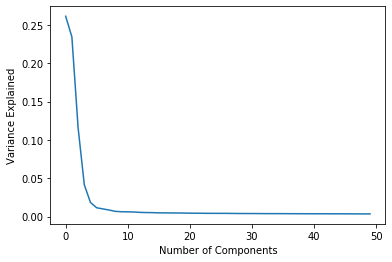

In [37]:
svd = TruncatedSVD(n_components=50)
svd.fit(X)
evr = svd.explained_variance_ratio_
ax = sns.lineplot(x = range(0,50), y = evr)
ax.set(xlabel = 'Number of Components', ylabel = 'Variance Explained')

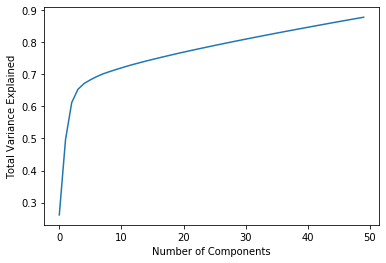

In [38]:
evr_sum = np.cumsum(evr)
ax = sns.lineplot(x = range(0,50), y = evr_sum)
ax.set(xlabel = 'Number of Components', ylabel = 'Total Variance Explained')
plt.savefig('./images/PCA_users.png', dpi = 300)

In [39]:
#We chose a evr_sum of 0.8
np.where(np.logical_and (evr_sum > 0.79, evr_sum < 0.81))

(array([25, 26, 27, 28, 29, 30]),)

In [40]:
opt_svd = TruncatedSVD(n_components=100)
svd_X = opt_svd.fit_transform(X)

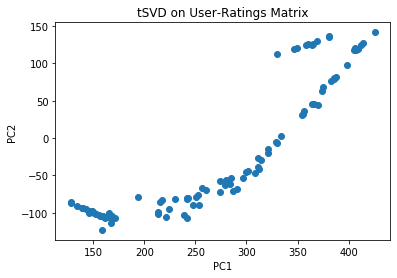

In [43]:
plt.scatter(svd_X[:,0],svd_X[:,1])
plt.title('tSVD on User-Ratings Matrix')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('./images/tSVD_on_User_rat_mat.png', dpi = 300)

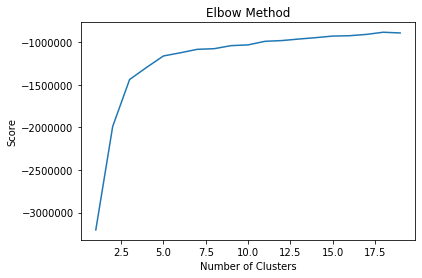

In [44]:
# TESTING FOR THE OPTIMAL NUMBER OF K CLUSTERS FOR THE KMEANS MODEL
number_clusters = range(1, 20) # BEST ONE WAS 4-7

kmeans = [MiniBatchKMeans(n_clusters=i, batch_size = 50, init= 'k-means++', max_iter = 100) for i in number_clusters]
score = [kmeans[i].fit(svd_X).score(svd_X) for i in tqdm_notebook(range(len(kmeans)))]
# PLOTTING ELBOW PLOT
plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.savefig('./images/elbow_method_kmeans_users.png', dpi = 300)
plt.show()

In [45]:
k_value = 6
kmeans_svd = MiniBatchKMeans(n_clusters=k_value, batch_size = 100, init= 'k-means++', max_iter = 100)
fitted_values_svd = kmeans_svd.fit(svd_X)
predicted_values_svd = kmeans_svd.predict(svd_X)

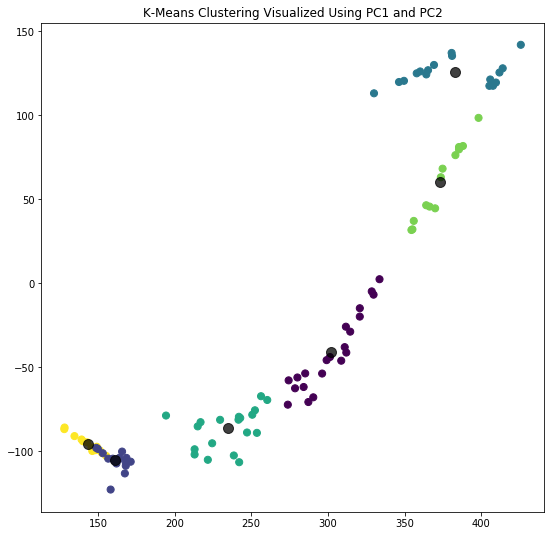

In [48]:
centers = kmeans_svd.cluster_centers_
plt.figure(figsize = (9,9))
plt.scatter(svd_X[:,0], svd_X[:,1], c=predicted_values_svd, s=50, cmap='viridis')
plt.scatter(centers[:,0], centers[:,1], c='black', s=100, alpha=0.75)
plt.title('K-Means Clustering Visualized Using PC1 and PC2')
plt.savefig('./images/Kmeans_Clustering_on_User_Data.png', dpi = 300)

In [47]:
# the highest rated jokes in each of the 6 clusters
[centers[i].argsort()[-5:][::-1] for i in range(len(centers))]

[array([ 0,  3,  7, 10,  6]),
 array([0, 2, 5, 3, 7]),
 array([ 0,  1,  2,  6, 10]),
 array([ 0,  4, 18, 23, 90]),
 array([ 0,  1,  3,  4, 13]),
 array([ 0,  2,  3, 11, 17])]